# Reinforcement Learning Final Project

Welcome to your Reinforcement Learning project! Join in groups of a maximum of 5 students on a project focused on developing an RL agent capable of solving an environment for decision-making in Autonomous Driving. The project deadline has been set to the 2nd of June.

Autonomous Driving has long been considered a field in which RL algorithms excel, and this project aims to leverage the power of RL to create an intelligent agent that can solve the Farama’s foundation “highway-env” project, namely the Highway environment (refer to https://highway-env.farama.org/environments/highway/).

## Project Requirements:

* The environments observation’s format can vary according to our preference, namely Kinematics, Grayscale Image, Occupancy grid and Time to collision (refer to https://highway-env.farama.org/observations/). In your solutions you should use 2 of these types.
* The agents actions can also vary, as continuous actions, discrete actions and discrete meta-actions (refer to https://highway-env.farama.org/actions/). In your solutions you should use 2 of these types.
* As for the algorithms to use, any algorithm is valid (seen or not in class), with a minimum requirement of 3 different algorithms used.
* Apart from the environment observation types and agent action types you must use environment’s configuration provided in the annexed notebook!
Note: Your delivery should comprise 4 solutions to the highway environment (corresponding to the combinations of the two environment observation’s types and the two agent’s action types), in which you just need to use one algorithm for each combination (knowing that you need to use at least 3 different algorithms).


## Project Objectives:

* Train an RL agent to solve the Highway environment: The primary objective of this project is to develop an RL agent that can maximize the reward given by the highway environment (refer to https://highway-env.farama.org/rewards/), which leverages to maximize speed while minimizing crash risk!
* Optimize decision-making using RL algorithms: Explore different RL algorithms to train the agent. Compare and analyse their effectiveness in learning and decision-making capabilities in the context of the environment.
* Explore and expand on the reward system: Although you should evaluate your agent with the reward function provided by the environment, you could/should expand it to better train your agent.
* Enhance interpretability and analysis: Develop methods to analyse the agent's decision-making process and provide insights into its strategic thinking. Investigate techniques to visualize the agent's evaluation of chess positions and understand its reasoning behind specific moves.



### Extra Objectives:

* Investigate transfer learning and generalization: Explore techniques for transfer learning to leverage knowledge acquired in related domains or from pre-training on large chess datasets. Investigate the agent's ability to generalize its knowledge.
* Explore multi agent approaches: The environment allows you to use more than one agent per episode. Explore multi agent alternatives to improve your learning times and overall benchmarks.


## Imports Required

You might need to restart the kernel after installation

In [1]:
!pip install gymnasium highway-env stable-baselines3[extra]

In [1]:
import gymnasium as gym

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm.notebook import tqdm
import itertools
import pickle
from stable_baselines3 import DQN
#from stable_baselines3.common.envs import DummyVecEnv
from gymnasium.spaces import Discrete, Box
from stable_baselines3 import A2C
import torch
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

import warnings
import logging

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='gymnasium')

# Set logging level to ERROR
logging.getLogger().setLevel(logging.ERROR)

## Environment Configuration

Apart from the environment observation types and agent action types you must use some of the environment’s configurations provided bellow!

In [ ]:
""" configuration = {

    # Parametrization bellow cannot be changed
    "lanes_count": 10, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
    "observation": {
        "type": "Kinematics"
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction",
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    "collision_reward": -1,  # The reward received when colliding with a vehicle. (Can be changed)
    "reward_speed_range": [20, 30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 15,  # [Hz] (Can be changed)
    "policy_frequency": 1,  # [Hz] (Can be changed)

    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
} """

' configuration = {\n\n    # Parametrization bellow cannot be changed\n    "lanes_count": 10, # The environment must always have 10 lanes\n    "vehicles_count": 50, # The environment must always have 50 other vehicles\n    "duration": 120,  # [s] The environment must terminate never before 120 seconds\n    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles\n    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2\n\n    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type\n    "observation": {\n        "type": "Kinematics"\n    },\n\n    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type\n    "action": {\n        "type": "DiscreteMetaAction",\n    },\n\n    # Parameterization bellow can be changed (as it refers mostly to the reward system)\n    "collision_reward": -1,  # The reward received when colliding with a vehicle. (

## Example Solution
### Solution 0
Environment Observation Type: **Kinematics** \
Agent Action Type: **DiscreteMetaAction** \
Algorithm Used: **Random**

Example of the environment's usage using a random policy.

In [ ]:
""" env = env = gym.make('highway-v0', render_mode='human', config=configuration)

obs, info = env.reset(seed=42)
done = truncated = False

Return = 0
n_steps = 1
Episode = 0
while not (done or truncated):
  # Dispatch the observations to the model to get the tuple of actions
  action = env.action_space.sample()
  # Execute the actions
  next_obs, reward, done, truncated, info = env.step(action)
  Return+=reward

  print('Episode: {}, Step: {}, Return: {}'.format(Episode, n_steps, round(Return,2)))
  n_steps+=1
env.close() """

" env = env = gym.make('highway-v0', render_mode='human', config=configuration)\n\nobs, info = env.reset(seed=42)\ndone = truncated = False\n\nReturn = 0\nn_steps = 1\nEpisode = 0\nwhile not (done or truncated):\n  # Dispatch the observations to the model to get the tuple of actions\n  action = env.action_space.sample()\n  # Execute the actions\n  next_obs, reward, done, truncated, info = env.step(action)\n  Return+=reward\n\n  print('Episode: {}, Step: {}, Return: {}'.format(Episode, n_steps, round(Return,2)))\n  n_steps+=1\nenv.close() "

### Solution 1
Environment Observation Type: OccupanyGrid\
Agent Action Type: Discrete Meta Actions\
Algorithm Used: Q-Table

## Solution 3
Environment Observation Type: Kinematics\
Agent Action Type: ContinuousActions (Discretized)\
Algorithm Used: DQN

In [2]:
continuous_action_configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,  # Maximum duration of each episode in seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"],
    },
    "action": {
        "type": "DiscreteAction",
        "actions_per_axis": 5,
        "steering_range": [-np.pi / 4, np.pi / 4],
        "acceleration_range": [-5, 5],
        "speed_range": [1, 30]
    },
    "collision_reward": -1,
    "reward_speed_range": [20, 30],
    "high_speed_reward": 0.4,
    "lane_change_reward": 0.2,
    "simulation_frequency": 15,
    "policy_frequency": 1,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
}

base_env = gym.make('highway-v0', config=continuous_action_configuration)

In [3]:
class NegativeVelocityPenaltyWrapper(gym.RewardWrapper):
    def __init__(self, env, penalty):
        super(NegativeVelocityPenaltyWrapper, self).__init__(env)
        self.penalty = penalty

    def reward(self, reward):
        # Get the agent's velocity
        velocity = self.env.vehicle.velocity[0]  # Assuming the velocity is the first feature
        if velocity < 0:
            reward += self.penalty
        return reward

In [4]:
#env = NegativeVelocityPenaltyWrapper(base_env, penalty=-0.05)
env = make_vec_env(lambda: base_env, n_envs=1)

In [5]:
original_env = env.envs[0]
def print_action_meanings(env):
    action_type = env.action_type
    cont_space = action_type.space()
    low = np.array([-1, -1])
    high = np.array([1, 1])
    axes = np.linspace(low, high, action_type.actions_per_axis).T
    all_actions = list(itertools.product(*axes))
    for i, action in enumerate(all_actions):
        acceleration = np.interp(action[0], [-1, 1], action_type.acceleration_range)
        steering = np.interp(action[1], [-1, 1], action_type.steering_range)
        print(f"Action {i}: Acceleration {acceleration:.2f}, Steering {steering:.2f}")

print_action_meanings(original_env)

Action 0: Acceleration -5.00, Steering -0.79
Action 1: Acceleration -5.00, Steering -0.39
Action 2: Acceleration -5.00, Steering 0.00
Action 3: Acceleration -5.00, Steering 0.39
Action 4: Acceleration -5.00, Steering 0.79
Action 5: Acceleration -2.50, Steering -0.79
Action 6: Acceleration -2.50, Steering -0.39
Action 7: Acceleration -2.50, Steering 0.00
Action 8: Acceleration -2.50, Steering 0.39
Action 9: Acceleration -2.50, Steering 0.79
Action 10: Acceleration 0.00, Steering -0.79
Action 11: Acceleration 0.00, Steering -0.39
Action 12: Acceleration 0.00, Steering 0.00
Action 13: Acceleration 0.00, Steering 0.39
Action 14: Acceleration 0.00, Steering 0.79
Action 15: Acceleration 2.50, Steering -0.79
Action 16: Acceleration 2.50, Steering -0.39
Action 17: Acceleration 2.50, Steering 0.00
Action 18: Acceleration 2.50, Steering 0.39
Action 19: Acceleration 2.50, Steering 0.79
Action 20: Acceleration 5.00, Steering -0.79
Action 21: Acceleration 5.00, Steering -0.39
Action 22: Acceleratio

In [6]:
""" rewards = []
avg_rewards = []

class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        return True

    def _on_rollout_end(self) -> None:
        # Get the reward for the last episode
        episode_reward = sum(self.locals['infos'][0]['episode']['r'] for i in range(len(self.locals['infos'])) if 'episode' in self.locals['infos'][i])
        if episode_reward:
            self.episode_rewards.append(episode_reward)
            avg_reward = np.mean(self.episode_rewards[-100:])  # Average of last 100 episodes
            rewards.append(episode_reward)
            avg_rewards.append(avg_reward)

callback = RewardLoggerCallback() """


class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.avg_rewards = []

    def _on_step(self) -> bool:
        return True

    def _on_rollout_end(self) -> None:
        episode_reward = sum(self.locals['infos'][0]['episode']['r'] for i in range(len(self.locals['infos'])) if 'episode' in self.locals['infos'][i])
        if episode_reward:
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(len(self.locals['infos']))
            avg_reward = np.mean(self.episode_rewards[-100:])  # Average of last 100 episodes
            self.avg_rewards.append(avg_reward)

callback = RewardLoggerCallback()

In [7]:
model = DQN('MlpPolicy', env, verbose=1)

Using cpu device


In [8]:
model.learn(total_timesteps=40000, callback=callback)

In [9]:
save_path = "C:/Users/laech/Documents/NOVA IMS/RL/Project Handout-20240526"
os.makedirs(save_path, exist_ok=True)
model_file = os.path.join(save_path, "dqn_current_new")

# Save the trained model
model.save(model_file)
#model = DQN.load(model_file)

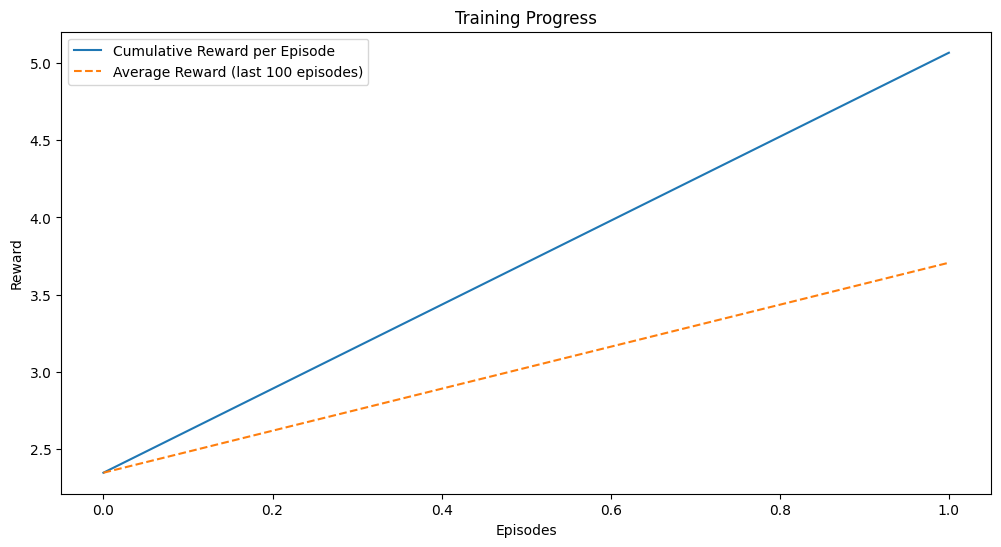

In [10]:
# Plotting cumulative and average rewards
plt.figure(figsize=(12, 6))
plt.plot(callback.episode_rewards, label='Cumulative Reward per Episode')
plt.plot(callback.avg_rewards, label='Average Reward (last 100 episodes)', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.legend()
plt.show()

In [11]:
# mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5)
# print(f"Mean reward: {mean_reward} +/- {std_reward}")

#### evaluation

In [12]:
default_config = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 100,  # [s]
    "collision_reward": -1,  # Default collision reward
    "right_lane_reward": 0.1,  # Default right lane reward
    "high_speed_reward": 0.4,  # Default high speed reward
    "lane_change_reward": 0,   # Default lane change reward
    "reward_speed_range": [20, 30],
    "normalize_reward": True,  # Enable normalization
    "offroad_terminal": False,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"]
    },
    "action": {
        "type": "DiscreteAction",
        "actions_per_axis": 5,
        "steering_range": [-np.pi / 4, np.pi / 4],
        "speed_range": [1, 30],
        "acceleration_range": [-5, 5]
    },
}

# Create the environment with custom configuration for training
env = make_vec_env(lambda: gym.make('highway-v0', config=default_config), n_envs=1)

In [13]:
""" episode_rewards = []
actions = []
positions = []
velocities = []
collisions = []
overtakes = []

# Evaluate the agent for 5 episodes
obs = env.reset()
for episode in range(10):  # Evaluate for 5 episodes
    done = False
    episode_reward = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        actions.append(int(action))
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        positions.append(obs[0][:2])  # Assuming the first two features are x and y positions
        velocities.append(obs[0][2:])  # Assuming the next two features are vx and vy velocities
        if 'collision' in info:
            collisions.append(info['collision'])
        if 'overtake' in info:
            overtakes.append(info['overtake'])
    episode_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward}, Actions taken = {actions[-20:]}")  # Print the last 20 actions for debugging
    obs = env.reset() """

# Evaluate the agent
episode_rewards = []
average_speeds = []
episode_lengths = []
all_velocities = []
actions = []
episode_velocities_list = []

obs = env.reset()
for episode in range(5):
    done = False
    episode_reward = 0
    total_speed = 0
    steps = 0
    episode_velocities = []
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        actions.append(int(action))
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        speed = np.linalg.norm(obs[0][2:])
        total_speed += speed
        steps += 1
        episode_velocities.append(speed)
        
    average_speeds.append(total_speed / steps)
    episode_lengths.append(steps)
    episode_rewards.append(episode_reward)
    all_velocities.extend(episode_velocities)
    episode_velocities_list.append(episode_velocities)
    obs = env.reset()

In [14]:
""" action_counts = np.bincount(actions, minlength=env.action_space.n)
action_percentages = action_counts / len(actions) * 100 """

' action_counts = np.bincount(actions, minlength=env.action_space.n)\naction_percentages = action_counts / len(actions) * 100 '

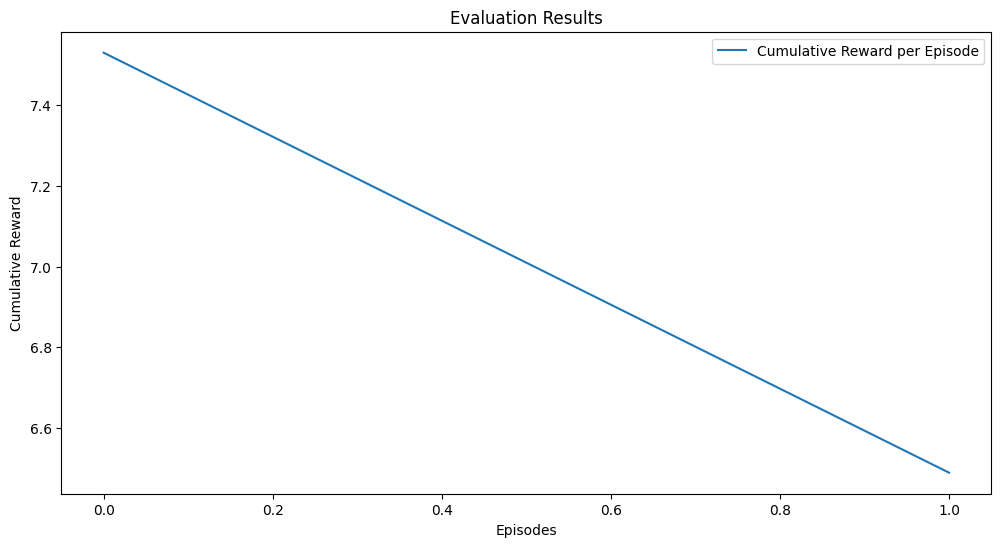

Average Speed: 0.11507729977369309


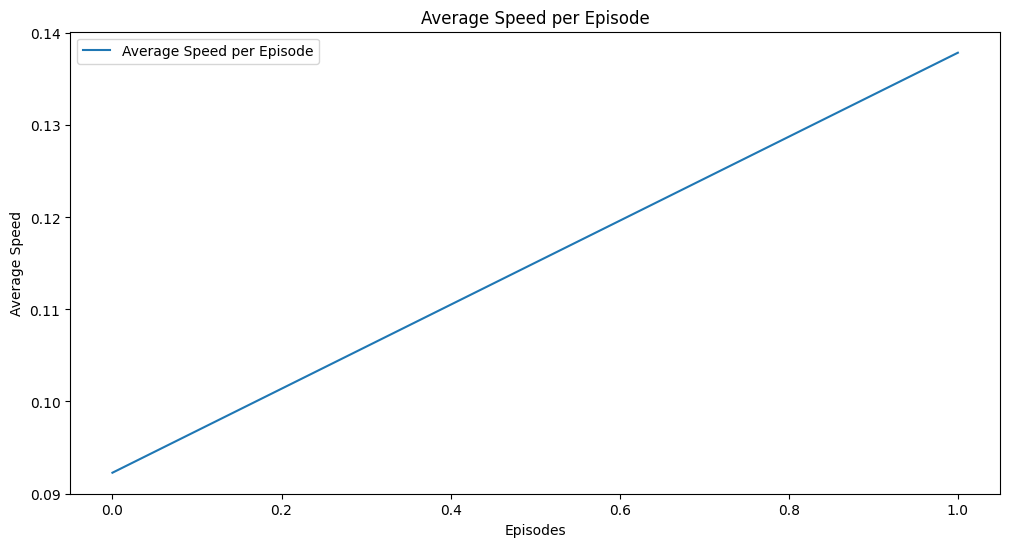

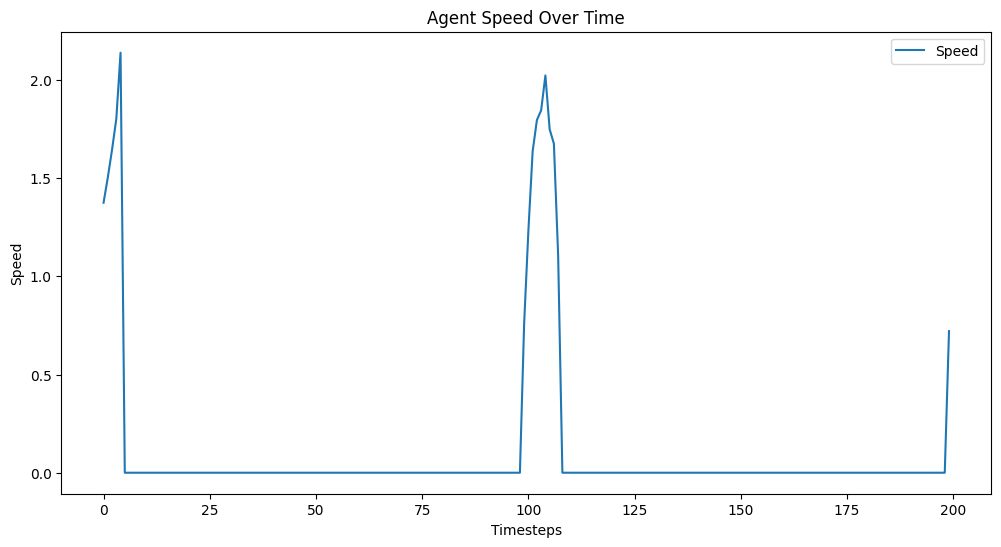

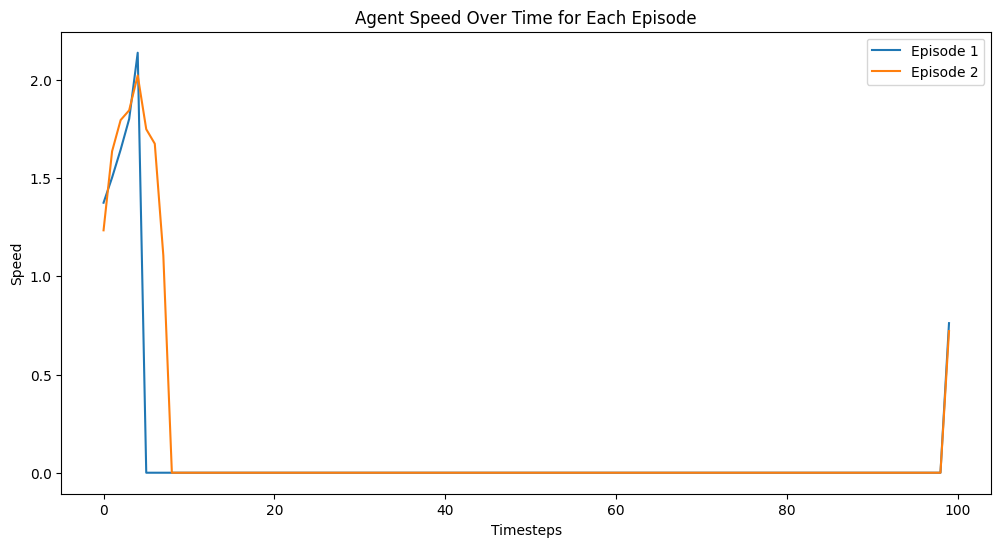

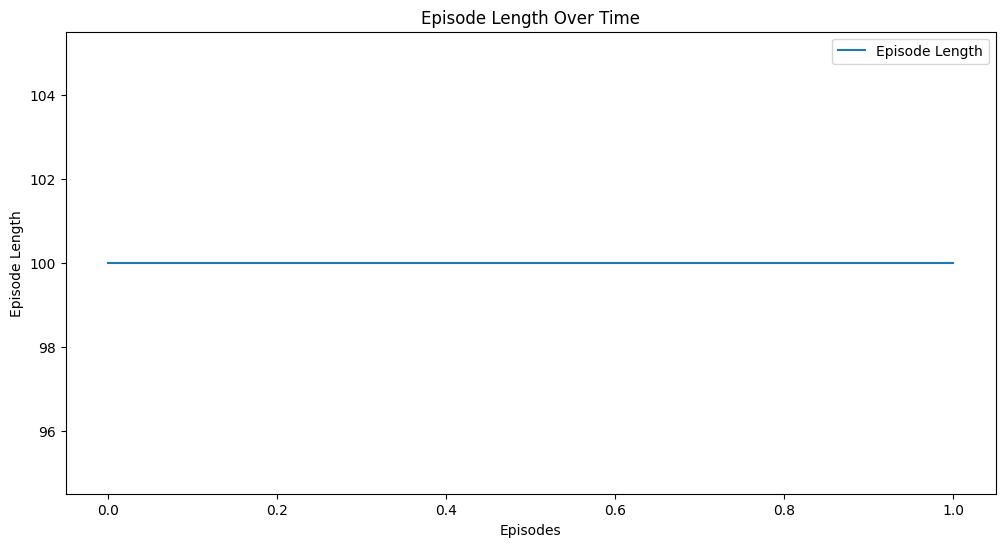

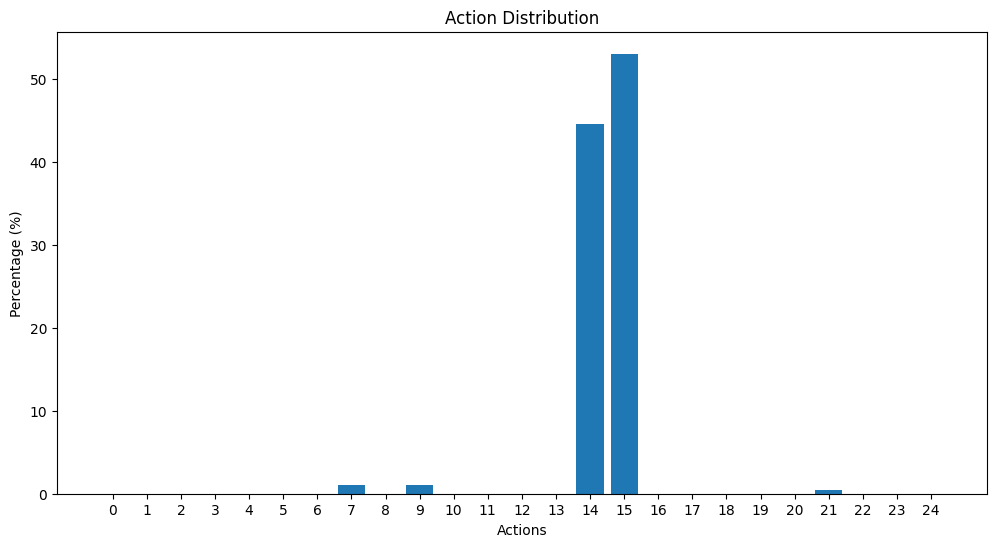

In [15]:
""" action_counts = np.bincount(actions, minlength=env.action_space.n)
action_percentages = action_counts / len(actions) * 100

positions = np.array(positions)
velocities = np.array(velocities)

# Plotting cumulative rewards per episode
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Cumulative Reward per Episode')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward per Episode')
plt.legend()
plt.show()


# Plotting action distribution
plt.figure(figsize=(12, 6))
plt.bar(range(env.action_space.n), action_percentages, tick_label=np.arange(env.action_space.n))
plt.xlabel('Actions')
plt.ylabel('Percentage (%)')
plt.title('Action Distribution')
plt.show()


# Plotting velocities
plt.figure(figsize=(12, 6))
plt.plot(velocities[:, 0], label='vx')
#plt.plot(velocities[:, 1], label='vy')
plt.xlabel('Timesteps')
plt.ylabel('Velocity')
plt.title('Agent Velocity Over Time')
plt.legend()
plt.show() """

# Plot evaluation results
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Cumulative Reward per Episode')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Evaluation Results')
plt.legend()
plt.show()

# Print evaluation metrics
print(f"Average Speed: {np.mean(average_speeds)}")

""" # Plotting average speed per episode
plt.figure(figsize=(12, 6))
plt.plot(average_speeds, label='Average Speed per Episode')
plt.xlabel('Episodes')
plt.ylabel('Average Speed')
plt.title('Average Speed per Episode')
plt.legend()
plt.show() """

""" # Plotting velocities over time
plt.figure(figsize=(12, 6))
plt.plot(all_velocities, label='Speed')
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Agent Speed Over Time')
plt.legend()
plt.show() """

# Plotting velocities over time for each episode
plt.figure(figsize=(12, 6))
for idx, episode_velocities in enumerate(episode_velocities_list):
    plt.plot(episode_velocities, label=f'Episode {idx + 1}')
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Agent Speed Over Time for Each Episode')
plt.legend()
plt.show()

# Plotting episode lengths
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths, label='Episode Length')
plt.xlabel('Episodes')
plt.ylabel('Episode Length')
plt.title('Episode Length Over Time')
plt.legend()
plt.show()

# Plotting action distribution
action_counts = np.bincount(actions, minlength=env.action_space.n)
action_percentages = action_counts / len(actions) * 100

plt.figure(figsize=(12, 6))
plt.bar(range(env.action_space.n), action_percentages, tick_label=np.arange(env.action_space.n))
plt.xlabel('Actions')
plt.ylabel('Percentage (%)')
plt.title('Action Distribution')
plt.show()


## Solution 4
Environment Observation Type: Kinematics\
Agent Action Type: ContinuousActions\
Algorithm Used: A2C

In [15]:
""" kinematics_continuous_configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,  # Maximum duration of each episode in seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"],
    },
    "action": {
        "type": "ContinuousAction",
        "acceleration_range": (-5, 5.0),
        "steering_range": (-0.7853981633974483, 0.7853981633974483),
        "longitudinal": True,
        "lateral": True,
        "dynamical": False,
        "clip": True
    },
    "collision_reward": -10,
    "reward_speed_range": [20, 30],
    "simulation_frequency": 15,
    "policy_frequency": 1,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
}

env = gym.make('highway-v0', config=kinematics_continuous_configuration, render_mode='human') """

' kinematics_continuous_configuration = {\n    "lanes_count": 4,\n    "vehicles_count": 50,\n    "duration": 40,  # Maximum duration of each episode in seconds\n    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",\n    "initial_spacing": 2,\n    "observation": {\n        "type": "Kinematics",\n        "features": ["x", "y", "vx", "vy"],\n    },\n    "action": {\n        "type": "ContinuousAction",\n        "acceleration_range": (-5, 5.0),\n        "steering_range": (-0.7853981633974483, 0.7853981633974483),\n        "longitudinal": True,\n        "lateral": True,\n        "dynamical": False,\n        "clip": True\n    },\n    "collision_reward": -10,\n    "reward_speed_range": [20, 30],\n    "simulation_frequency": 15,\n    "policy_frequency": 1,\n    "screen_width": 800,\n    "screen_height": 600,\n    "centering_position": [0.5, 0.5],\n    "scaling": 5,\n    "show_trajectories": True,\n    "render_agent": True,\n    "offscreen_rendering": False,\n}\n\nenv = gym.make(

In [16]:
continuous_action_configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,  # Maximum duration of each episode in seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"],
    },
    "action": {
        "type": "ContinuousAction",
        "steering_range": [-np.pi / 4, np.pi / 4],
        "acceleration_range": [-5, 5],
        "speed_range": [1, 30]
    },
    "collision_reward": -1,
    "reward_speed_range": [20, 30],
    "simulation_frequency": 15,
    "policy_frequency": 1,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
}

base_env = gym.make('highway-v0', config=continuous_action_configuration)

In [17]:
env = make_vec_env(lambda: base_env, n_envs=1)

In [18]:
class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.actions = []
        self.positions = []
        self.velocities = []
        self.collisions = []
        self.lane_changes = []

    def _on_step(self) -> bool:
        return True

    def _on_rollout_end(self) -> None:
        episode_reward = sum(self.locals['infos'][0]['episode']['r'] for i in range(len(self.locals['infos'])) if 'episode' in self.locals['infos'][i])
        if episode_reward:
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(len(self.locals['infos']))
            for info in self.locals['infos']:
                if 'action' in info:
                    self.actions.append(info['action'])
                if 'observation' in info:
                    self.positions.append(info['observation'][:2])
                    self.velocities.append(info['observation'][2:])
                if 'collision' in info:
                    self.collisions.append(info['collision'])
                if 'lane_change' in info:
                    self.lane_changes.append(info['lane_change'])

callback = RewardLoggerCallback()

In [19]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=40000, callback=callback)

Using cpu device


In [ ]:
save_path = "C:/Users/laech/Documents/NOVA IMS/RL/Project Handout-20240526"
os.makedirs(save_path, exist_ok=True)
model_file = os.path.join(save_path, "a2c_current_new")

# Save the trained model
model.save(model_file)
model = A2C.load(model_file)

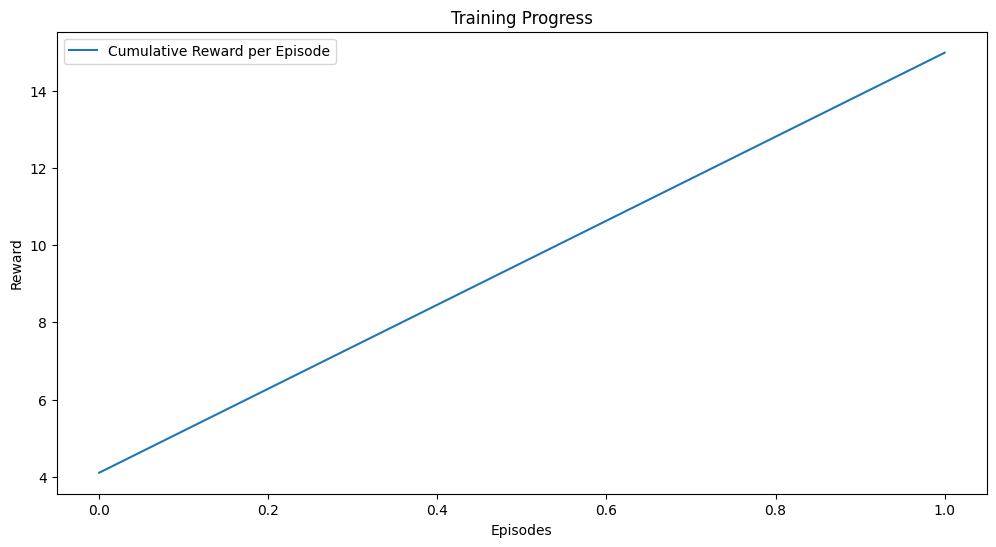

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(callback.episode_rewards, label='Cumulative Reward per Episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.legend()
plt.show()

#### evaluate

In [21]:
continuous_action_configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 100,  # Maximum duration of each episode in seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"],
    },
    "action": {
        "type": "ContinuousAction",
        "steering_range": [-np.pi / 4, np.pi / 4],
        "acceleration_range": [-5, 5],
        "speed_range": [1, 30]
    },
    "collision_reward": -1,
    "reward_speed_range": [20, 30],
    "simulation_frequency": 15,
    "policy_frequency": 1,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
}

env = gym.make('highway-v0', config=continuous_action_configuration)
env = make_vec_env(lambda: env, n_envs=1)

In [22]:
# Evaluate the agent
episode_rewards = []
episode_lengths = []
average_speeds = []
all_velocities = []
episode_velocities_list = []

obs = env.reset()
for episode in range(5):
    done = False
    episode_reward = 0
    total_speed = 0
    steps = 0
    episode_velocities = []
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        speed = np.linalg.norm(obs[0][2:])
        total_speed += speed
        steps += 1
        episode_velocities.append(speed)
        
    average_speeds.append(total_speed / steps)
    episode_lengths.append(steps)
    episode_rewards.append(episode_reward)
    all_velocities.extend(episode_velocities)
    episode_velocities_list.append(episode_velocities)
    obs = env.reset()

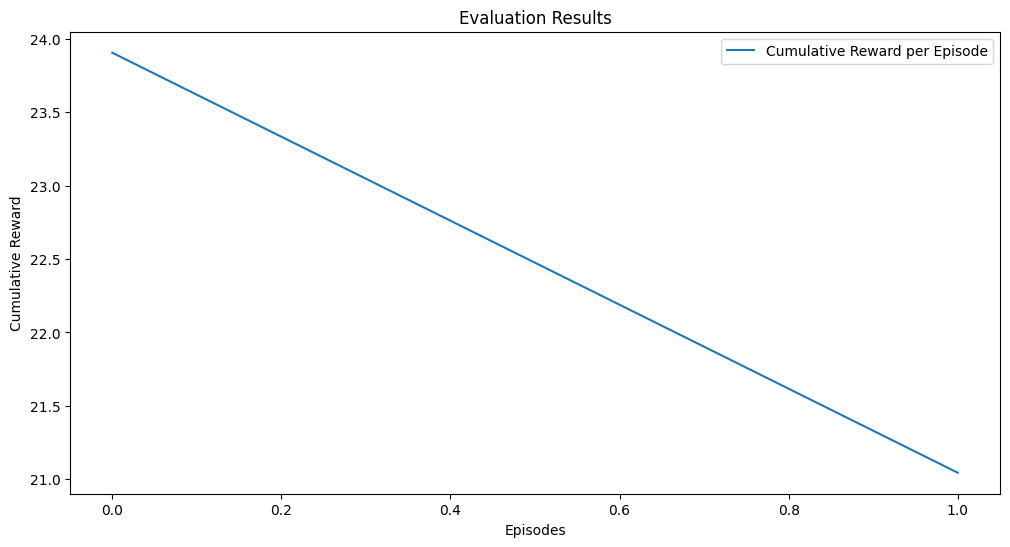

Average Speed: 0.11567752212285995


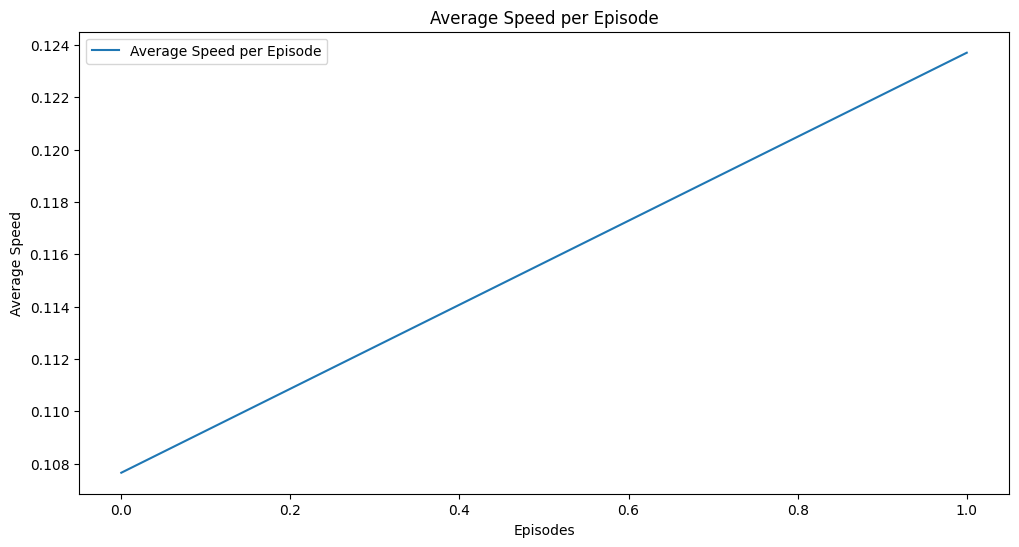

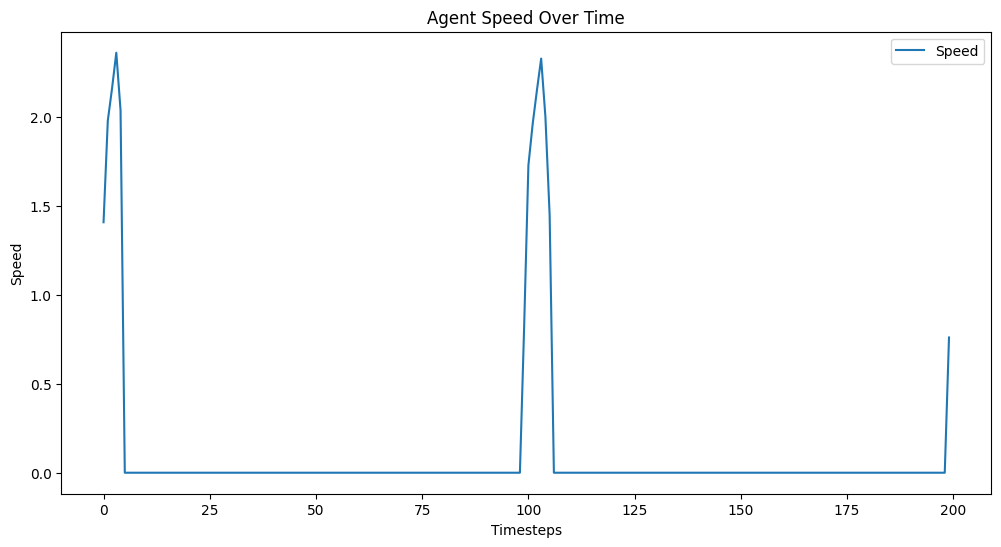

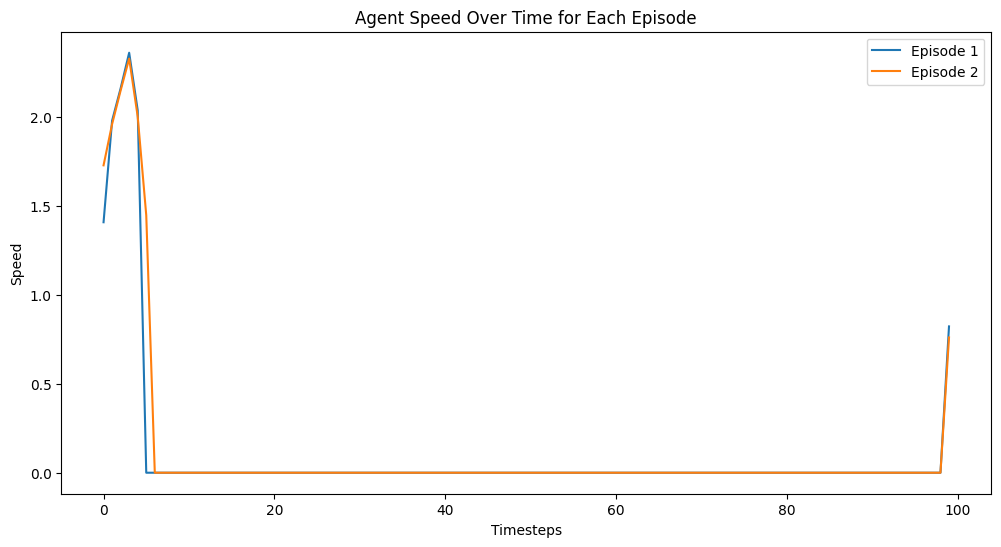

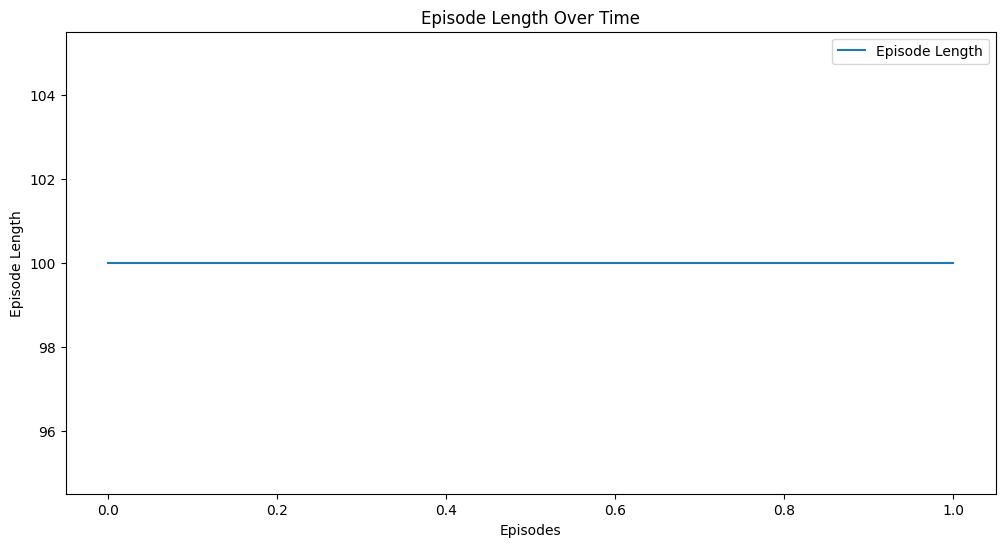

In [23]:
# Plot evaluation results
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Cumulative Reward per Episode')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Evaluation Results')
plt.legend()
plt.show()

# Print evaluation metrics
print(f"Average Speed: {np.mean(average_speeds)}")

""" # Plotting average speed per episode
plt.figure(figsize=(12, 6))
plt.plot(average_speeds, label='Average Speed per Episode')
plt.xlabel('Episodes')
plt.ylabel('Average Speed')
plt.title('Average Speed per Episode')
plt.legend()
plt.show() """

""" # Plotting velocities over time
plt.figure(figsize=(12, 6))
plt.plot(all_velocities, label='Speed')
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Agent Speed Over Time')
plt.legend()
plt.show() """

# Plotting velocities over time for each episode
plt.figure(figsize=(12, 6))
for idx, episode_velocities in enumerate(episode_velocities_list):
    plt.plot(episode_velocities, label=f'Episode {idx + 1}')
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Agent Speed Over Time for Each Episode')
plt.legend()
plt.show()

# Plotting episode lengths
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths, label='Episode Length')
plt.xlabel('Episodes')
plt.ylabel('Episode Length')
plt.title('Episode Length Over Time')
plt.legend()
plt.show()